In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Data Description: What do we *know* about the PLAICRAFT server and its users?
==============

***Players***
- Consists of 7 columns and 196 unique observations/players <br>
  **Experience**: *a factor*, either Beginner, Amateur, Pro or Veteran <br>
  **Subscribe**: *a boolean*, either true or false: are users subscribed to <br>
  **hashedEmail**: *a string*, an encrypted version of the email given by a user <br>
  **played_hours**: *a double*, the number of hours a player contributed to the project through playtime<br>
  **name**: *a string*, the first name of a user <br>
  **gender**: *a string*, either Male, Female, or Non-binary <br>
  **Age**: *an integer*, the age of a player <br>

***Sessions***
- Consists of 5 columns and 1535 unique observations/player sessions <br>
  **hashedEmail**: *a string*, an encrypted version of the email given by a user <br>
  **start_time**: *a string*, has both the start date in D/M/Y format and the start time in military time <br>
  **end_time**: *a string*, has both the ebd date in D/M/Y format and the end time in military time <br>
  **original_start_time**: *a string*, UNIX time measurement for start_time, which is the number of seconds since January 1, 1970 UTC <br>
  **original_end_time**: *a string*,  UNIX time measurement for end_time, which is the number of seconds since January 1, 1970 UTC <br>
  <br>

**Observable Issues**  

*In the Players dataset:*  
While there are thousands of session records, there are fewer than 200 registered users. This may not be enough data for reliable conclusions, especially with outliers—such as those who played briefly or signed up without playing. It also raises questions about repeat players and whether the dataset is evenly distributed or biased.  

*In the Sessions dataset:*  
The data is not tidy. Start and end time columns contain multiple variables (day, month, year, and time in minutes/seconds) making analysis difficult. UNIX time measurements lack precision.  

**Non-Observable, but Potential, Issues**  

*In the Players dataset:*  
Are certain demographics (age, expertise, gender, etc.) over or underrepresented? How might this affec data collection and research validity?  

*In the Sessions dataset:*  
Are there hidden variables influencing player activity that aren’t recorded? E.G. if an email prompted more players to join a certain week, causing extra activity, the dataset wouldn’t reflect that.  


Questions: What can we *learn* about the PLAICRAFT server and its users?
======

A broad question I'd like to address is which "kinds" of players are most likely to contribute a large amount of data to the project

More specifically, I'd like to know: 

> Can factors such as gender and age successfully predict self-described experience levels the players data set?

Our data is structured so that a K-NN algorithm can be applied with minor adjustments! Gender, which is currently a string, can be converted to a factor. If treated as a spectrum, male and female could become 1 and 0, with non-binary and missing values set to 0.5. Both age and the gender variable would need to be standardized to grant them equal weight in distance calculations.

Data Analysis and Visualization: What can we *see* about the PLAICRAFT server and its users?
====

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_age,median_age,mean_played_hours,median_played_hours,gender,experience
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
20.52062,19,5.845918,0.1,Male,Amateur


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


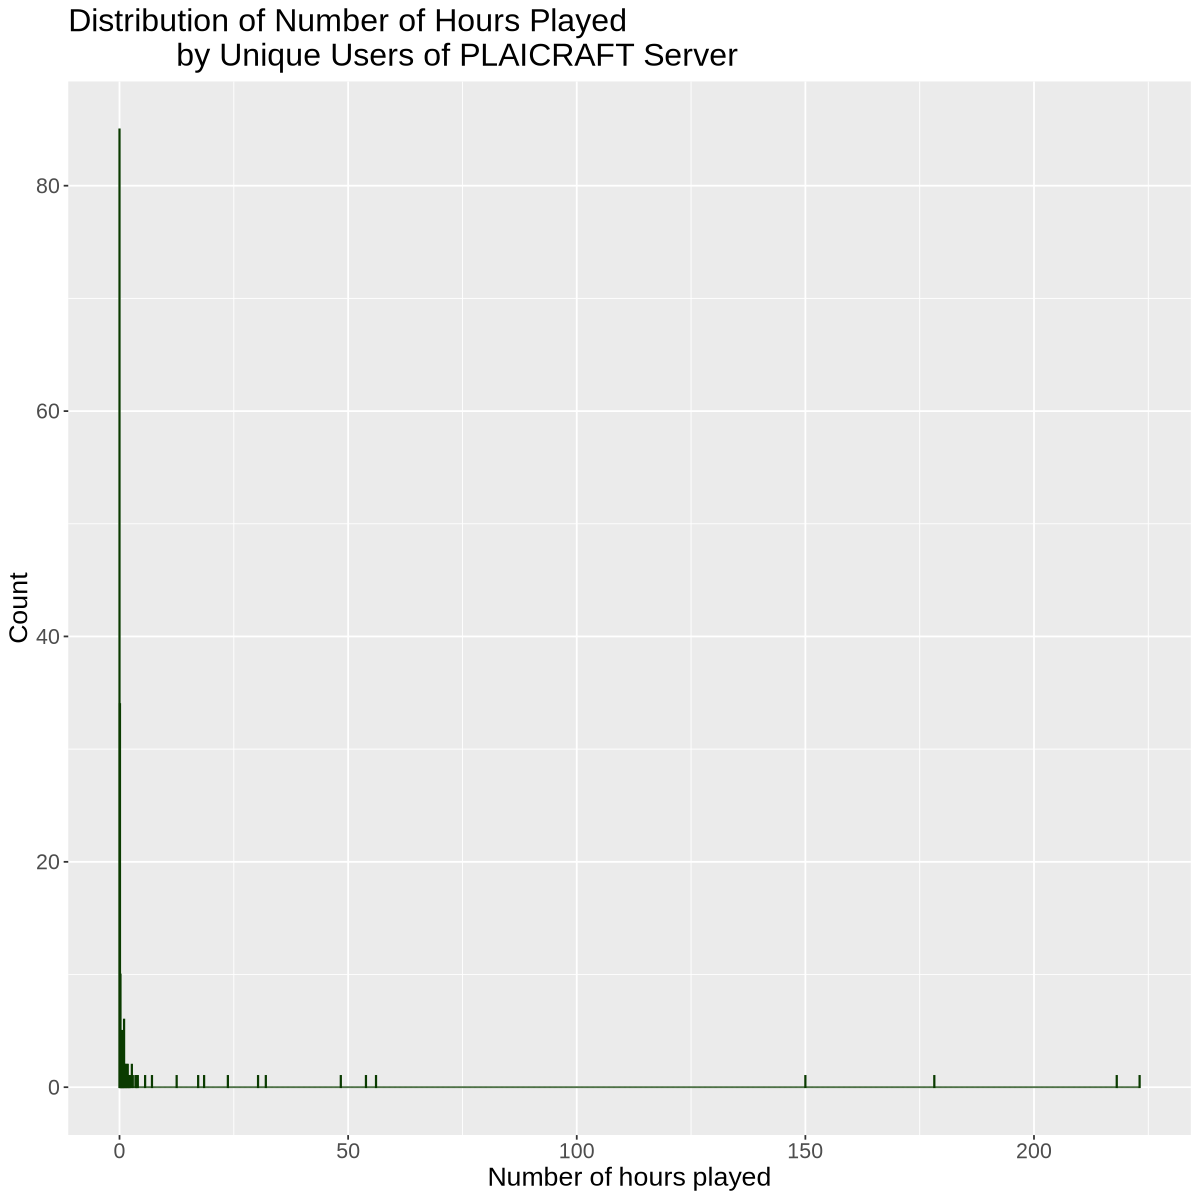

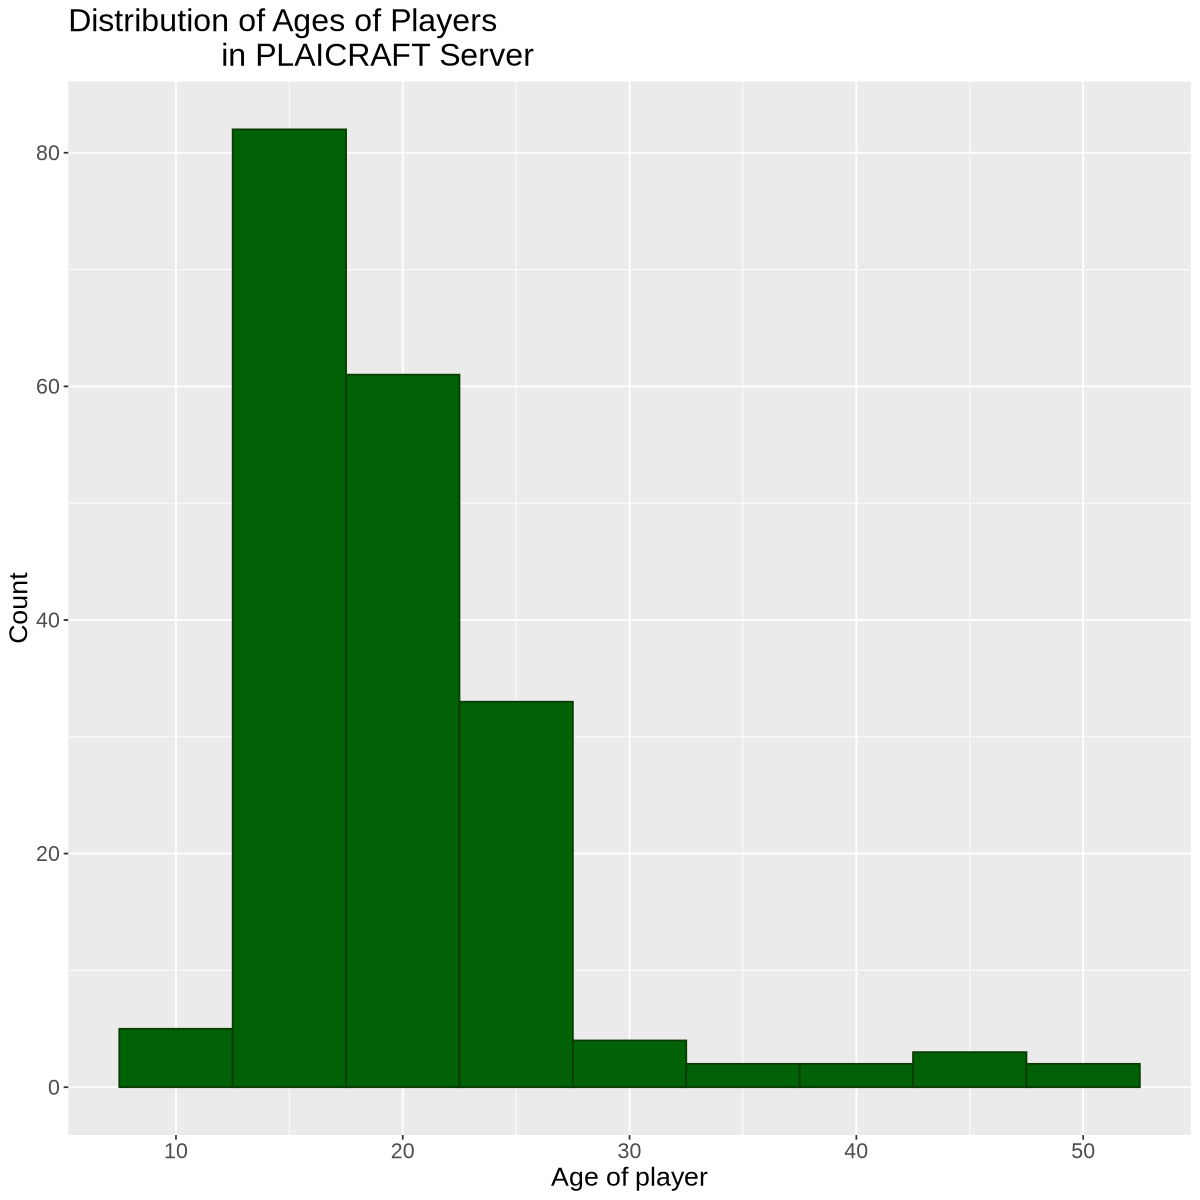

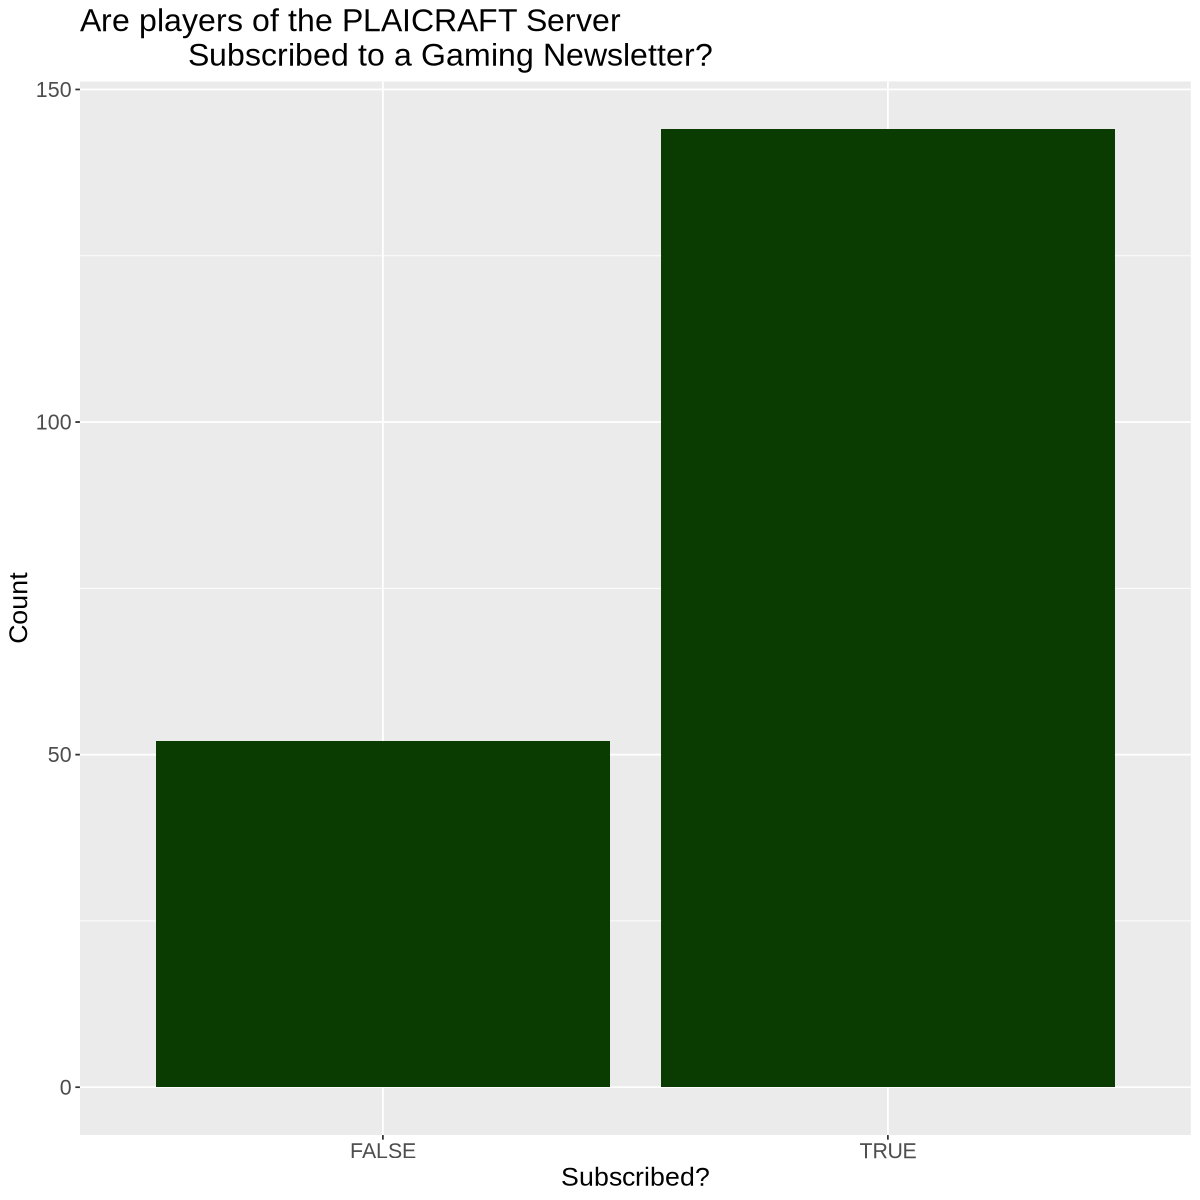

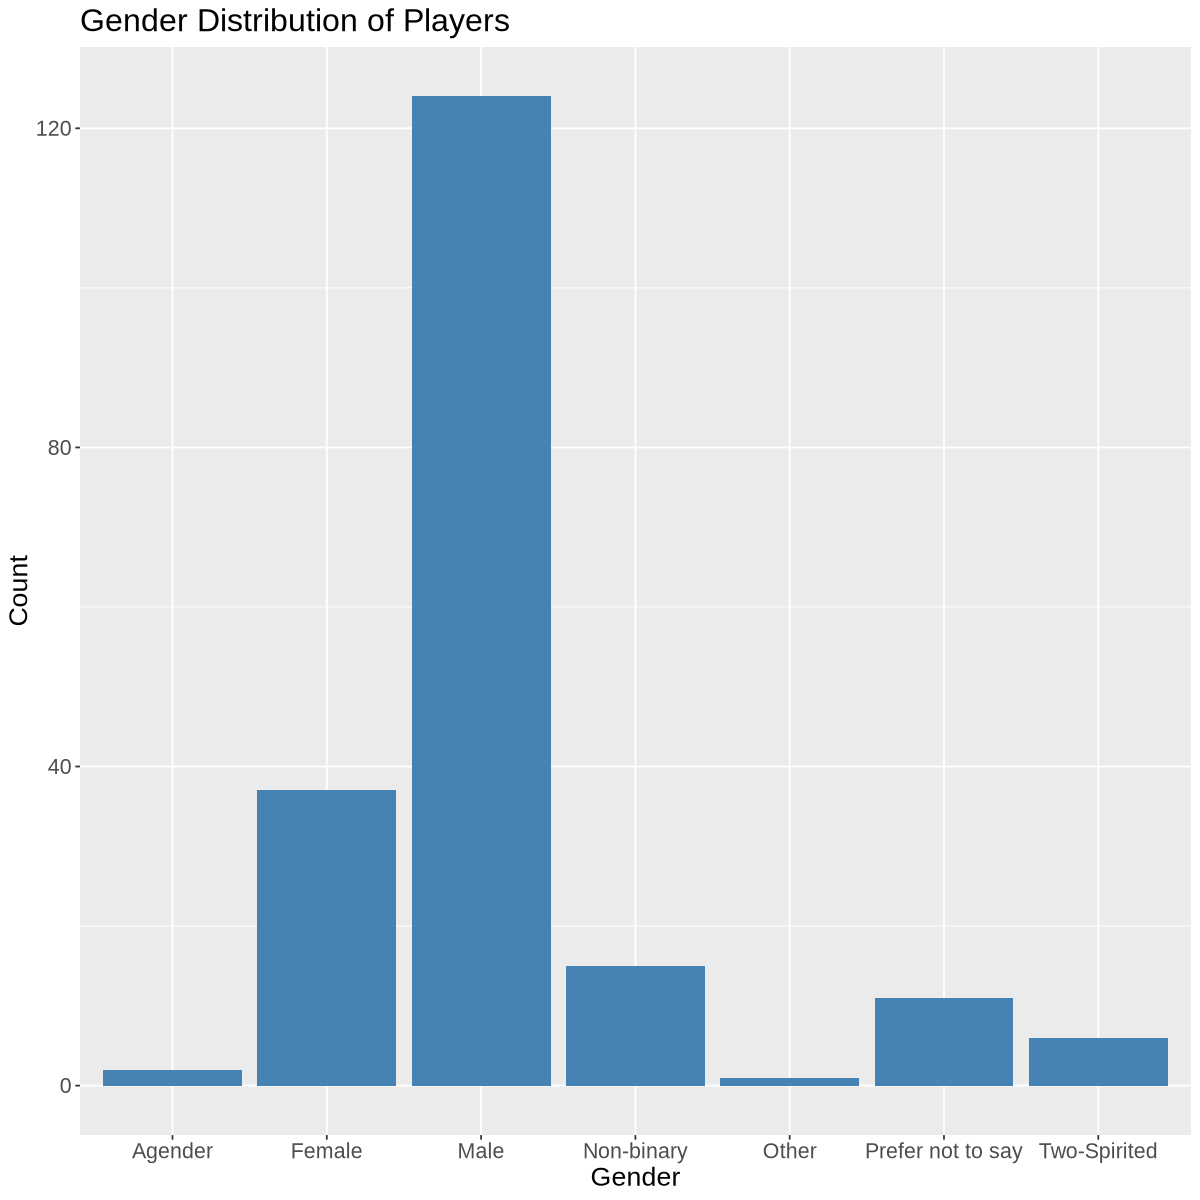

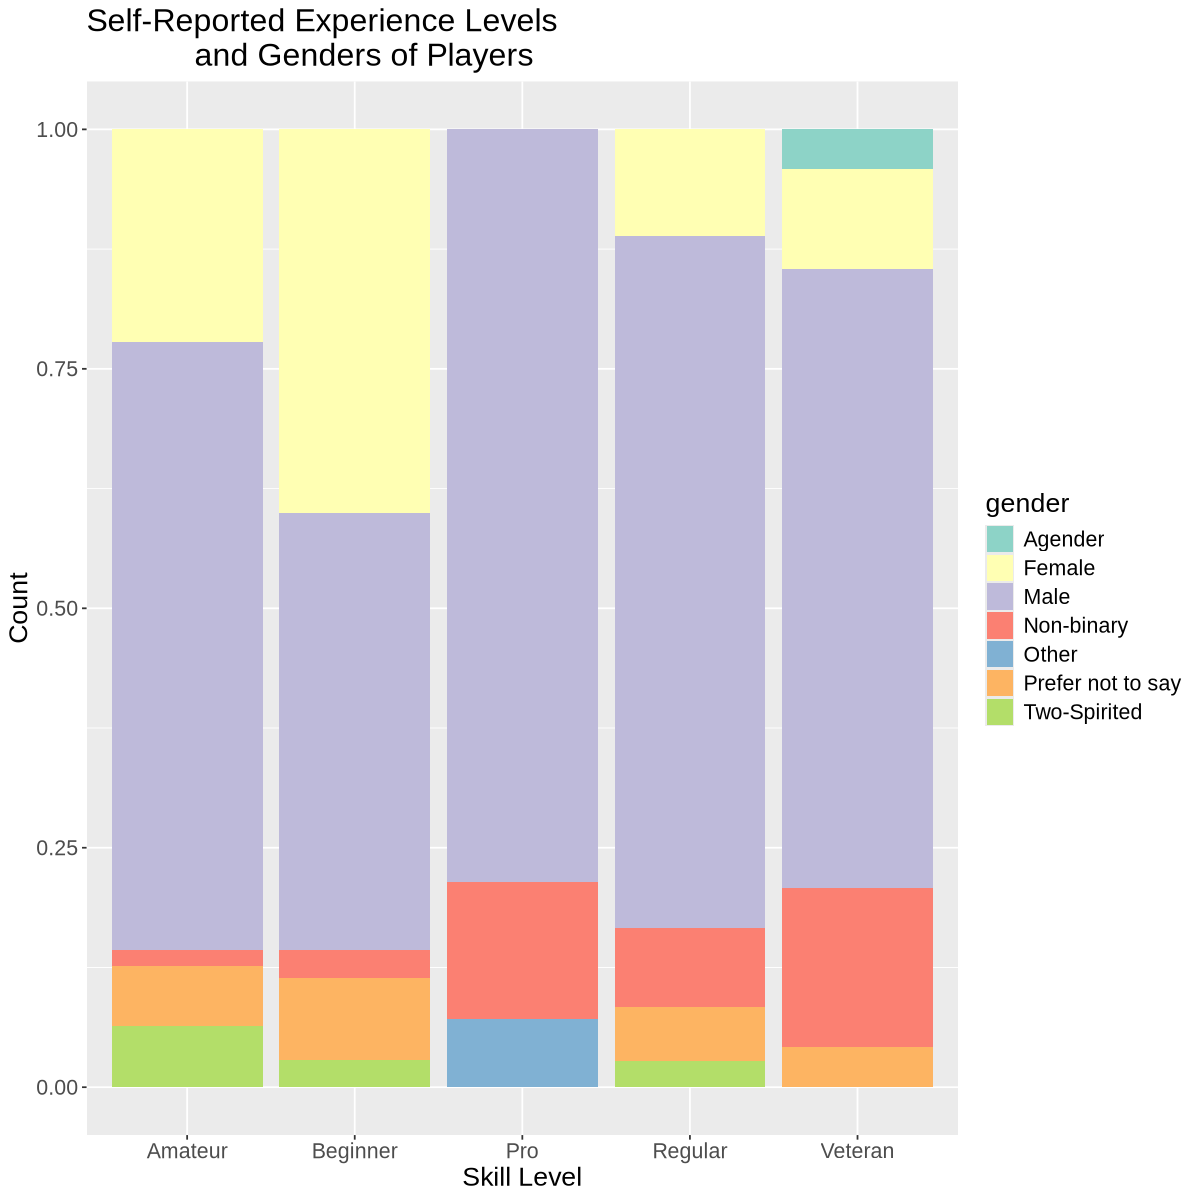

In [3]:
players <- read_csv("https://raw.githubusercontent.com/ellailan/PLAICRAFT-Data-Analysis/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/ellailan/PLAICRAFT-Data-Analysis/refs/heads/main/sessions.csv")

#looking at the most common responses and averages in the dataset, players

mean_hours <- players |> summarize(mean_played_hours = mean(played_hours, na.rm = TRUE))
mean_age <- players |> summarize(mean_age = mean(Age, na.rm = TRUE)) 

median_hours <- players |> summarize(median_played_hours = median(played_hours, na.rm = TRUE))
median_age <- players |> summarize(median_age = median(Age, na.rm = TRUE)) 

gender <- players |> select(gender) |> count(gender, sort = TRUE) 
most_pop_gender <- gender |> 
                    slice_head(n = 1) |> 
                    select(- n) 

experience <- players |> 
                select(experience) |> 
                count(experience, sort = TRUE) 

most_pop_experience <- experience |> 
                        slice_head(n = 1) |>
                        select(- n) 

players_summaries <- bind_cols(mean_age, median_age, mean_hours, median_hours, most_pop_gender, most_pop_experience)

players_summaries

#graphing numerical variables, to better understand their distributions
options(repr.plot.width = 10, repr.plot.height = 10) 

play_distribution <- players |> ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 0.1, fill = "#006106", color = "#0a3b00") +
    labs(x = "Number of hours played", y = "Count") +
    ggtitle("Distribution of Number of Hours Played
            by Unique Users of PLAICRAFT Server") +
    theme(text = element_text(size = 16))

age_distribution <- players |> ggplot(aes(x = Age)) +
  geom_histogram(binwidth = 5, fill = "#006106", color = "#0a3b00") +
    labs(x = "Age of player", y = "Count") +
         ggtitle("Distribution of Ages of Players 
                 in PLAICRAFT Server") +
    theme(text = element_text(size = 16))

subscribe <- players |> ggplot(aes(x = subscribe)) +
  geom_bar(fill = "#0a3b00") +
  labs(title = "Subscription Status", x = "Subscribed?", y = "Count") +
    ggtitle("Are players of the PLAICRAFT Server 
            Subscribed to a Gaming Newsletter?") +
    theme(text = element_text(size = 16))

gender <- players |> ggplot(aes(x = gender)) +
  geom_bar(fill = "steelblue") +
  labs(title = "Gender Distribution of Players", x = "Gender", y = "Count") +
    theme(text = element_text(size = 16)) 


experience_gender <- players |> ggplot(aes(x = experience, fill = gender)) +
  geom_bar(position = "fill") +
  labs(color = "Gender", y = "Count", x = "Skill Level") + 
    ggtitle("Self-Reported Experience Levels
            and Genders of Players") +
    theme(text = element_text(size = 16)) +
    scale_fill_brewer(palette = 'Set3')

play_distribution
age_distribution
subscribe
gender
experience_gender


Exploring the dataset
===
***Most popular experience level***: Amateur <br>
***Most popular gender***: Male <br>
***Mean age***: 20.5 <br>
***Median age***: 19 <br>
<br>
Age is a skewed distribution with a significant peak at 15-20, probably because a majority of participants were undergraduate college students. There are some outliars in the adult range. <br>

<br>

***Mean played hours***: 5.8
<br>
***Median played hours***: 0.1<br>
<br>

Play time is a significantly skewed distribution, with most players only playing for a few minutes. The mean is skewed by some extreme outliers, including a few players that played for hundreds of hours. <br> 

Most players are subscribed to the newsletter. 

When exploring gender and experience, men are more likely to identify as Veterans or Professionals. No women self-identified as Professionals, and few as Veterans, while beginner numbers were nearly equal. **This reflects the higher male participation in the survey, but the gender gap across expertise levels is still notable. The absence of women in the Professional category is a statistical anomaly!**  

Methods and Plan
====
To explore if factors such as gender and age successfully predict experience, I want to use a K-NN Nearest Neighbour algorithm that uses both age and experience to predict what category someone would self-identitfy their expertise level as.  <br>

This model is suitable for categorical predictions using variables with enough variance, like gender and age. I may exclude time played, as most players have similar values.  

K-NN makes no assumptions about data shape, but potential issues include selecting the wrong K value or overrepresentation of certain groups, like men, affecting accuracy.  

I'll split the data into **25% training and 75% testing** to maximize evaluation data while keeping enough for training. I'll cross-validate K in **increments of 5 or 10** to efficiently find an optimal value given the dataset's size.